<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - fine-tuning

In [ ]:
!nvidia-smi

Tue Aug  2 14:24:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### import helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-03 20:34:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-03 20:34:13 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### get data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-03 20:34:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   204MB/s    in 0.8s    

2022-08-03 20:34:22 (204 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [41]:
import tensorflow as tf
IMG_SIZE = (225,225); BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [42]:
train_data, train_data.class_names

(<BatchDataset element_spec=(TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [43]:
#visualize a batch
for imgs, labels in train_data.take(1):
  print(imgs, labels)

tf.Tensor(
[[[[7.22977066e+01 5.42977028e+01 3.05536728e+01]
   [7.39296036e+01 5.68989792e+01 3.09602242e+01]
   [9.71676331e+01 7.69787445e+01 4.97344475e+01]
   ...
   [2.31020908e+01 1.57243452e+01 5.91321802e+00]
   [2.37054195e+01 1.67054195e+01 6.70542002e+00]
   [1.88541870e+01 1.18541870e+01 1.85418665e+00]]

  [[5.80148888e+01 4.16143990e+01 1.98593311e+01]
   [1.04901466e+02 8.88962708e+01 6.41948013e+01]
   [9.91771088e+01 8.16104431e+01 5.39193306e+01]
   ...
   [2.69513321e+01 2.09513321e+01 8.95133209e+00]
   [2.67014599e+01 1.97014599e+01 9.70145988e+00]
   [1.84910259e+01 1.14910259e+01 1.87500370e+00]]

  [[8.61937103e+01 6.99603806e+01 5.31960793e+01]
   [8.05915527e+01 6.52715530e+01 4.55982246e+01]
   [1.04092964e+02 8.74377747e+01 6.36370354e+01]
   ...
   [2.71003437e+01 2.11003437e+01 8.81073761e+00]
   [2.40397701e+01 1.78064365e+01 6.27310324e+00]
   [1.96397991e+01 1.34064665e+01 2.04217958e+00]]

  ...

  [[7.84021225e+01 6.21223602e+01 3.59289742e+01]
   [8

### experiment 1: pure feature extraction + data augmentation

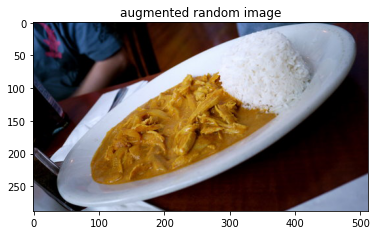

In [46]:
from tensorflow.keras.layers.experimental import preprocessing as pre #augments on gpu and only during train
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import os

data_aug = tf.keras.Sequential([
    pre.RandomFlip("horizontal"),
    pre.RandomRotation(0.2),
    pre.RandomZoom(0.2)
], name="data_augmentation")

target_class = random.choice(train_data.class_names)
target_dir = ''.join([train_dir,'/',target_class])
img = ''.join([target_dir,
               '/',
               random.choice(os.listdir(target_dir))])

aug_img = data_aug(mpimg.imread(img))
plt.title('augmented random image')
plt.imshow(aug_img/255)

In [61]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE)+(3,), name="input_layer") #normalizing not needed for efficientnet
#x = data_aug(inputs, training=True)
x = base_model(inputs)
print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
print(x.shape)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

(None, 7, 7, 1280)
(None, 1280)


In [62]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [63]:
#model checkpoint callback
save_path = "model_checkpoints/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [64]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)/4),
                    callbacks=[checkpoint_callback,
                               create_tensorboard_callback(dir_name="models",
                                                           experiment_name="feature_extraction")])

Saving TensorBoard log files to: models/feature_extraction/20220803-220801
Epoch 1/3
23/24 [===========================>..] - ETA: 0s - loss: 1.8967 - accuracy: 0.4212
Epoch 1: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 13s 259ms/step - loss: 1.8905 - accuracy: 0.4213 - val_loss: 1.3476 - val_accuracy: 0.6941
Epoch 2/3
23/24 [===========================>..] - ETA: 0s - loss: 1.1370 - accuracy: 0.7622
Epoch 2: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 4s 167ms/step - loss: 1.1354 - accuracy: 0.7613 - val_loss: 0.8989 - val_accuracy: 0.7993
Epoch 3/3
23/24 [===========================>..] - ETA: 0s - loss: 0.8429 - accuracy: 0.8043
Epoch 3: saving model to model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 5s 202ms/step - loss: 0.8411 - accuracy: 0.8040 - val_loss: 0.7388 - val_accuracy: 0.8141


In [65]:
model.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.7489 - accuracy: 0.8132


[0.7488507032394409, 0.8131999969482422]

In [66]:
for i,layer in enumerate(base_model.layers): print(i, layer.name)

0 input_18
1 rescaling_15
2 normalization_15
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3

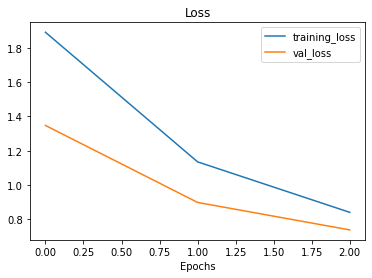

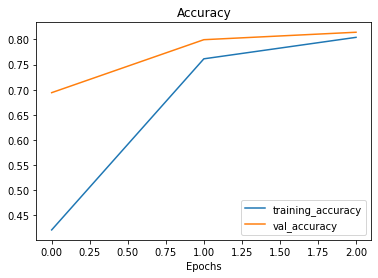

In [67]:
plot_loss_curves(history)

### getting a feature vector

In [68]:
#globalavgpool2d compresses 4-d to 2-d via averaging middle 2 axis to make a feature vector

tf.random.set_seed(42)

input_shape = (1,4,4,3)
tensor = tf.random.normal(input_shape)

pooled_tensor = tf.keras.layers.GlobalAvgPool2D()(tensor)
tensor.shape,pooled_tensor.shape


(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

### loading checkpoints and weights

In [69]:
#load and evaluate

model.load_weights(save_path)

In [71]:
model.evaluate(test_data)

79/79 [==============================] - 8s 87ms/step - loss: 0.7489 - accuracy: 0.8132


[0.7488508224487305, 0.8131999969482422]